In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
#importing colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mydrive_path='/content/drive/MyDrive/'

In [ ]:
#pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 2.0 MB/s eta 0:00:00


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline



from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Exploratory Data Analysis


In [ ]:
# Reading the input from folder
master_df = pd.read_csv(mydrive_path+'sample30.csv')
df=master_df.copy()
df.sample(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
6359,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2015-09-08T00:00:00.000Z,False,True,5,My husband will only eat Hormel chili without ...,Hormel chili,NaN,NaN,jkpeeps,Positive
24185,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-12-06T00:00:00.000Z,NaN,True,4,Good story line and special effects. Best vers...,Good special effects,NaN,NaN,surfdude,Positive
5486,AVpf0thK1cnluZ0-r8vR,Warner Bros.,"Movies, Music & Books,Movies,New Movie Release...",Warner Home Video,100:Complete First Season (blu-Ray),2014-11-05T00:00:00.000Z,NaN,True,5,Great show!!! A MUST GET FOR EVERY FAN OUT THE...,cool show!,NaN,NaN,sleestak50,Positive
15192,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2012-04-04T00:00:00.000Z,False,True,5,I have used this product several times. I love...,It helped me to get organized fast!,NaN,NaN,rljgallup,Positive
8197,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-04T23:12:58.000Z,NaN,True,5,I love the smell and the way are so convenient...,Great Product,NaN,NaN,fabnguyen3,Positive


In [ ]:
### Total reviews
total = len(df['reviews_text'])
print ("Number of reviews: ",total)

### How many unique reviewers?
print ("Number of unique reviewers: ",len(df['reviews_username'].unique()))
reviewer_prop = float(len(df['reviews_username'].unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))

### Average star score
print ("Average rating score: ",round(df['reviews_rating'].mean(),3))

Number of reviews:  30000
Number of unique reviewers:  24915
Prop of unique reviewers:  0.831
Average rating score:  4.483


In [ ]:
#data overivew
print('rows: ', df.shape[0])
print('columns: ', df.shape[1])
print('\nfeatures: ', df.columns.to_list())
print('\nmissing vlues: ', df.isnull().values.sum())
print('\nUnique values: \n', df.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [ ]:
# Info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

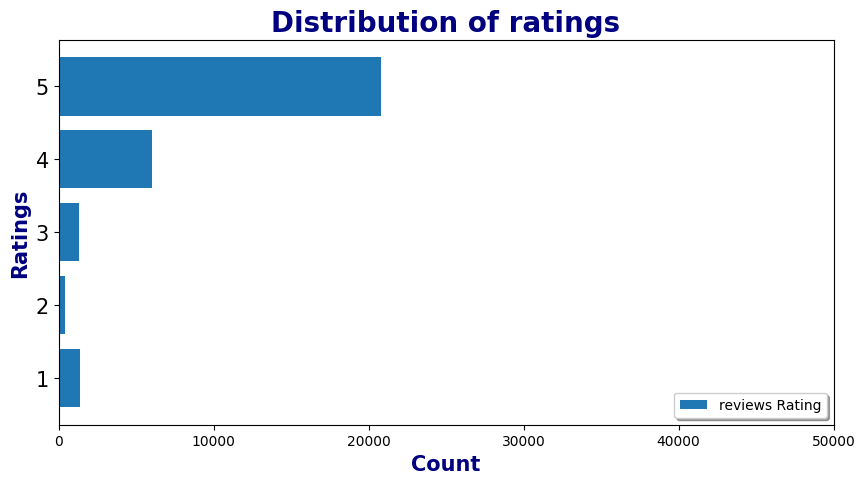

In [ ]:
# Number of occurences for each rating
#plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(df['reviews_rating'].value_counts().index)
y = list(df['reviews_rating'].value_counts())
plt.barh(x, y)
ticks_x = np.linspace(0, 50000, 6) # (start, end, no of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks(size=15)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.legend(['reviews Rating'], shadow=True, loc=4)

<ipython-input-17-e120d9ef1ed0>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





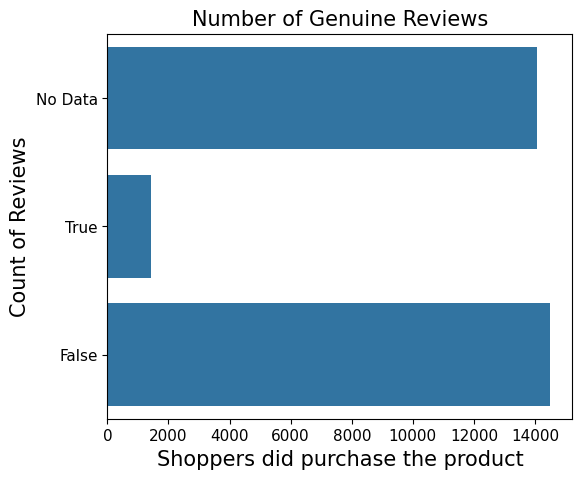

In [ ]:
#Replace the Nan values to No Data for reviewers did purchase or not
df['reviews_didPurchase'].fillna('No Data', inplace=True)
#Distribution of reviews for actual purchasing customers
plt.figure(figsize=(6,5))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=15)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=15)
ax.axes.set_title('Number of Genuine Reviews', fontsize=15)
ax.tick_params(labelsize=11)

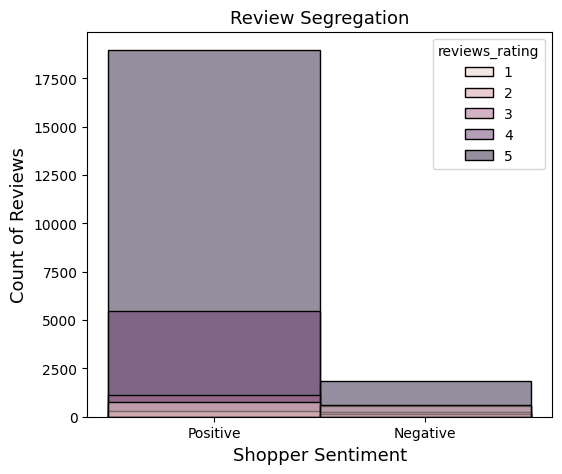

In [ ]:
plt.figure(figsize=(6,5))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="Shopper Sentiment", fontsize=13)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=13)
ax.axes.set_title('Review Segregation', fontsize=13)
ax.tick_params(labelsize=10)

In [ ]:
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


# Data Cleaning

In [ ]:
# Finding the number of rows with Null values
df.isnull().sum()

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,0
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


From above, we observe reviews_userCity,reviews_userProvince has the maximum number of nulls. From the business understaning as well, since these attributes does not play a vital role, we can remove them.

In [ ]:
# dropping columns with maximum NULLs
df = df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [ ]:
print("shape of the dataframe =",df.shape)
print("Nulls\n" ,round((df.isnull().sum()*100/len(df)),2))

shape of the dataframe = (30000, 13)
Nulls
 id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_didPurchase    0.00
reviews_doRecommend    8.57
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64


In [ ]:
# Before Updating the user sentiment columns
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [ ]:
# for correcting the user sentiment according to rating
def review_sentiment_clear(x):
  if x >= 3 :
    return 'Postive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [ ]:
df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)
# After corrections for user sentiment
df['user_sentiment'].value_counts()

,count
user_sentiment,
Postive,28196
Negative,1804


# Text Preprocessing

In [ ]:
#Common functions for cleaning the text data
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import html

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= stopwords.words('english')

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas
def normalize_and_lemmaize(input_text):
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Take the Review comment and user sentiment as dataframe
review_df = df[['reviews_text','user_sentiment']]
review_df.head()


,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Postive
1,Good flavor. This review was collected as part...,Postive
2,Good flavor.,Postive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


In [ ]:
# create a new column lemmatized_review using the emmatize_text function
review_df['lemmatized_text'] = review_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))
review_df.head()

<ipython-input-28-44c2cf38853f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the...,Postive,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,Postive,good flavor review collect part promotion
2,Good flavor.,Postive,good flavor
3,I read through the reviews on here before look...,Negative,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,Negative,husband buy gel us gel cause irritation felt l...


In [ ]:
# new dataframe with lemmatized text and user sentiment
review_new_df = review_df[['lemmatized_text','user_sentiment']]
review_new_df

,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,Postive
1,good flavor review collect part promotion,Postive
2,good flavor,Postive
3,read review look buy one couple lubricants ult...,Negative
4,husband buy gel us gel cause irritation felt l...,Negative
...,...,...
29995,get conditioner influenster try im love far oi...,Postive
29996,love receive review purpose influenster leave ...,Postive
29997,first love smell product wash hair smooth easy...,Postive
29998,receive influenster never go back anything els...,Postive


In [ ]:
#Encode the negative and postive to 0 and 1 respectively
review_new_df['user_sentiment'] = review_new_df['user_sentiment'].map({'Negative':0,'Postive':1})
review_new_df.head()

<ipython-input-30-6d6bf15b2db6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,1
1,good flavor review collect part promotion,1
2,good flavor,1
3,read review look buy one couple lubricants ult...,0
4,husband buy gel us gel cause irritation felt l...,0


In [ ]:
!pip install  imbalanced-learn

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE


# Train and Test Divide
x_train,x_test,y_train,y_test = train_test_split(review_new_df['lemmatized_text'],review_new_df['user_sentiment'],train_size=0.75,random_state=45,stratify=review_new_df['user_sentiment'])
y_train.value_counts()

,count
user_sentiment,
1,21147
0,1353


# Feature Extraction using Count Vectorizer and TFIDF Transformer

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
x_count = count_vect.fit_transform(x_train)


tfidf_transformer = TfidfTransformer()
x_train_transformed = tfidf_transformer.fit_transform(x_count)
x_train_transformed.shape

(22500, 14754)

In [ ]:
#creating the pickle for countvectorizer and TFIDF Transformer
import pickle
pickle_path = '/content/drive/MyDrive/Pickle_files/'
with open(pickle_path +'count_vector.pkl', 'wb') as f:
  pickle.dump(count_vect,f)
with open(pickle_path +'tfidf_transformer.pkl', 'wb') as r:
  pickle.dump(tfidf_transformer,r)


In [ ]:
count = Counter(y_train)
print('Before sampling :',count)

sampler = SMOTE()

x_train_sm,y_train_sm = sampler.fit_resample(x_train_transformed,y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1: 21147, 0: 1353})
After sampling : Counter({1: 21147, 0: 21147})


# Training text classification model

Let's start with Logistic Regression model

In [ ]:
# Function for Metrics
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics


In [ ]:
lr = LogisticRegression()
lr.fit(x_train_sm,y_train_sm)

LogisticRegression()

In [ ]:
y_pred = lr.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[20812   335]
 [  645 20502]]
sensitivity of the Logistic Regression = 0.970000
specificity of the Logistic Regression = 0.980000
Accuracy Score of Logistic Regression = 0.976829
ROC AUC score of Logistic Regression = 0.976829
Report=
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21147
           1       0.98      0.97      0.98     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294

**************************************************


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)

RandomForestClassifier()

In [ ]:
y_pred_rf = rf.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[21144     3]
 [    0 21147]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 0.999929
ROC AUC score of RandomForestClassifier = 0.999929
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


###XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_sm,y_train_sm)
y_pred_xgbc = xgb_classifier.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbc,'XGBClassifier',peformance)

**************************************************
Confusion Matrix =
[[20833   314]
 [  106 21041]]
sensitivity of the XGBClassifier = 0.990000
specificity of the XGBClassifier = 0.990000
Accuracy Score of XGBClassifier = 0.990070
ROC AUC score of XGBClassifier = 0.990070
Report=
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21147
           1       0.99      0.99      0.99     21147

    accuracy                           0.99     42294
   macro avg       0.99      0.99      0.99     42294
weighted avg       0.99      0.99      0.99     42294

**************************************************


In [ ]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.976829,0.976829,0.983923,0.976658
1,RandomForestClassifier,0.999929,0.999929,0.999858,0.999929
2,XGBClassifier,0.990070,0.990070,0.985296,0.990118


##Hyper parameter tuning of models

In [ ]:
n_estimators = [200,400,600]
max_depth = [6,10,15]
min_samples_leaf = [5,6,8]
criterion  = ['gini','entropy']
params = {'n_estimators':n_estimators,
          'max_depth':max_depth,
          'min_samples_leaf': min_samples_leaf,
          'criterion':criterion}

In [ ]:
grid_cv = GridSearchCV(estimator=rf,
                       param_grid=params,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [ ]:
grid_cv.fit(x_train_sm,y_train_sm)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 10, 15],
                         'min_samples_leaf': [5, 6, 8],
                         'n_estimators': [200, 400, 600]},
             scoring='roc_auc', verbose=1)

In [ ]:
rf_final=grid_cv.best_estimator_
rf_final

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=600)

In [ ]:
#pickle.dump(rf_final,open(mydrive_path+'pickle_file/RandomForest_classifier.pkl','wb'))

pickle_path = '/content/drive/MyDrive/Pickle_files/'
with open(pickle_path +'RandomForest_classifier.pkl', 'wb') as f:
  pickle.dump(rf_final,f)

In [ ]:
grid_cv.best_score_

0.9776896552696888

In [ ]:
y_pred_rfgcv = rf_final.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rfgcv,'RandomForestClassifier with hyperparmater',performance)

**************************************************
Confusion Matrix =
[[17909  3238]
 [  617 20530]]
sensitivity of the RandomForestClassifier with hyperparmater = 0.970000
specificity of the RandomForestClassifier with hyperparmater = 0.850000
Accuracy Score of RandomForestClassifier with hyperparmater = 0.908852
ROC AUC score of RandomForestClassifier with hyperparmater = 0.908852
Report=
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     21147
           1       0.86      0.97      0.91     21147

    accuracy                           0.91     42294
   macro avg       0.92      0.91      0.91     42294
weighted avg       0.92      0.91      0.91     42294

**************************************************


In [ ]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.976829,0.976829,0.983923,0.976658
1,RandomForestClassifier,0.999929,0.999929,0.999858,0.999929
2,XGBClassifier,0.990070,0.990070,0.985296,0.990118
3,RandomForestClassifier with hyperparmater,0.908852,0.908852,0.863766,0.914171


In [ ]:
n_estimators = [200,400,600]
params_1 = {'n_estimators':n_estimators}

In [ ]:
max_depth = [5,6,7,10]

params_2 = {'max_depth':max_depth
}
grid_cv_boost2 = GridSearchCV(estimator=xgb_classifier,
                       param_grid=params_2,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [ ]:
grid_cv_boost2.fit(x_train_sm,y_train_sm)
print('Best score for GradientBoosting=',grid_cv_boost2.best_score_)
grid_cv_boost2.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score for GradientBoosting= 0.9974803895415972


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
min_samples_split = [10,20,30]
params_2 = {'min_samples_split': min_samples_split
}
grid_cv_boost3 = GridSearchCV(estimator=grid_cv_boost2.best_estimator_,
                       param_grid=params_2,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

grid_cv_boost3.fit(x_train_sm,y_train_sm)
print('Best score for GradientBoosting=',grid_cv_boost3.best_score_)
grid_cv_boost3.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:36:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.




Best score for GradientBoosting= 0.9974803895415972


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgbgcv2 = grid_cv_boost3.best_estimator_.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbgcv2,'GradientBoostClassifier with param2',peformance)
performance

**************************************************
Confusion Matrix =
[[20994   153]
 [    9 21138]]
sensitivity of the GradientBoostClassifier with param2 = 1.000000
specificity of the GradientBoostClassifier with param2 = 0.990000
Accuracy Score of GradientBoostClassifier with param2 = 0.996170
ROC AUC score of GradientBoostClassifier with param2 = 0.996170
Report=
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21147
           1       0.99      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9768288646143661,
  'Roc_auc_score': 0.976828864614366,
  'Precision': 0.9839228295819936,
  'F1_score': 0.9766577743902439},
 {'Model_name': 'RandomForestClassifier',
  'Accuracy': 0.9999290679529012,
  'Roc_auc_score': 0.999929067952901,
  'Precision': 0.9998581560283688,
  'F1_score': 0.9999290729838995},
 {'Model_name': 'XGBClassifier',
  'Accuracy': 0.9900695134061569,
  'Roc_auc_score': 0.9900695134061569,
  'Precision': 0.9852961835635683,
  'F1_score': 0.9901181120888429},
 {'Model_name': 'RandomForestClassifier with hyperparmater',
  'Accuracy': 0.9088523194779401,
  'Roc_auc_score': 0.9088523194779402,
  'Precision': 0.8637664086166273,
  'F1_score': 0.9141712122898809},
 {'Model_name': 'GradientBoostClassifier with param2',
  'Accuracy': 0.9961696694566605,
  'Roc_auc_score': 0.9961696694566605,
  'Precision': 0.992813865013386,
  'F1_score': 0.9961826664781563}]

In [ ]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.976829,0.976829,0.983923,0.976658
1,RandomForestClassifier,0.999929,0.999929,0.999858,0.999929
2,XGBClassifier,0.990070,0.990070,0.985296,0.990118
3,RandomForestClassifier with hyperparmater,0.908852,0.908852,0.863766,0.914171
4,GradientBoostClassifier with param2,0.996170,0.996170,0.992814,0.996183


In [ ]:
rf_final = pickle.load(open(pickle_path+'RandomForest_classifier.pkl','rb'))

In [ ]:
final_model = GradientBoostingClassifier(max_depth=10, min_samples_split=20, n_estimators=600)

In [ ]:
final_model.fit(x_train_sm,y_train_sm)

GradientBoostingClassifier(max_depth=10, min_samples_split=20, n_estimators=600)

In [ ]:
pickle.dump(final_model,open(pickle_path+'final_model.pkl','wb'))

In [ ]:
#Evaluatopn between lr , rf and boost
test_performance=[]
test_word_vect = count_vect.transform(x_test)
test_tfidf_vect = tfidf_transformer.transform(test_word_vect)

y_test_pred_lr = lr.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_lr,'Logistic Regression',test_performance)

y_test_pred_xgbc = xgb_classifier.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_xgbc,'XGBoost Classifier',test_performance)

y_test_pred_rf = rf_final.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_rf,'Tuned RandomForestClassifier',test_performance)

y_test_pred_xgb = final_model.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_xgb,'Tuned GradientBoostClassifier',test_performance)

test_metrics_df = pd.DataFrame(test_performance)
test_metrics_df

**************************************************
Confusion Matrix =
[[ 351  100]
 [ 267 6782]]
sensitivity of the Logistic Regression = 0.960000
specificity of the Logistic Regression = 0.780000
Accuracy Score of Logistic Regression = 0.951067
ROC AUC score of Logistic Regression = 0.870196
Report=
              precision    recall  f1-score   support

           0       0.57      0.78      0.66       451
           1       0.99      0.96      0.97      7049

    accuracy                           0.95      7500
   macro avg       0.78      0.87      0.82      7500
weighted avg       0.96      0.95      0.95      7500

**************************************************
**************************************************
Confusion Matrix =
[[ 286  165]
 [ 105 6944]]
sensitivity of the XGBoost Classifier = 0.990000
specificity of the XGBoost Classifier = 0.630000
Accuracy Score of XGBoost Classifier = 0.964000
ROC AUC score of XGBoost Classifier = 0.809625
Report=
              precisio

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.951067,0.870196,0.985469,0.973656
1,XGBoost Classifier,0.964000,0.809625,0.976790,0.980930
2,Tuned RandomForestClassifier,0.945733,0.784342,0.974293,0.971034
3,Tuned GradientBoostClassifier,0.968133,0.815975,0.977426,0.983146


Considering roc_auc_score ,performance.
Logistic Regression is having more score and have good accuracy

In [ ]:
pickle.dump(lr,open(pickle_path+'/model.pkl','wb'))

# 5. Recommedation system


*  User and User recommedation system
*  Item and Item recommedation system




start with user and user recommendation system

In [ ]:
df = pd.read_csv(mydrive_path+'sample30.csv')
df.sample(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
27319,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-12-06T00:00:00.000Z,NaN,True,4,Good children's movie. Plot not quite as inter...,Cute kids movie,NaN,NaN,joey,Positive
21732,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-09-07T00:02:19.000Z,NaN,NaN,1,I have used Nexxus Exxtra Gel for years and ju...,Exxtra Gel Super Hold,NaN,NaN,bjh1,Positive
27558,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-10T00:00:00.000Z,NaN,True,5,My kids love this movie!! Just as good if not ...,Great Movie,NaN,NaN,jsegotta,Positive
14612,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-31T00:00:00.000Z,False,True,5,Excellent product. I use it for disinfecting a...,Clorox bleach,NaN,NaN,mimmie,Positive
5260,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainme...",SONY CORP,The Resident Evil Collection 5 Discs (blu-Ray),2017-05-13T00:00:00.000Z,NaN,True,5,Great way for fans of the series to get their ...,Cheap way to own all 5 RE movies,NaN,NaN,jayb,Positive


In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.70,random_state=45)
print('train shape = ',train.shape)
print('test shape = ',test.shape)

train shape =  (21000, 15)
test shape =  (9000, 15)


In [ ]:
#using train dataset and create correlation matrix
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)
train_pivot

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zwithanx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#Creating the train and test dataset for predicting and evaluating the correlation
#fill 1 in place of Nan for prediction
train_pivot1 = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)

In [ ]:
# adjusted cosine similarity
import numpy as np

def cosine_similarity(df):
    # using the adjusted cosine similarity
    mean_df = np.nanmean(df,axis=1)
    substracted_df = (df.T - mean_df).T # Normalized dataset
    # using the pairwise_distance for cosine similarity
    user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    return user_correlation,substracted_df

In [ ]:
user_corr_matrix,normalized_df = cosine_similarity(train_pivot1)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [ ]:
user_corr_matrix.shape

(18205, 18205)

In [ ]:
user_corr_matrix[user_corr_matrix < 0] = 0
user_corr_matrix.shape

(18205, 18205)

In [ ]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot1.fillna(0))
user_pred_ratings

array([[ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       ...,
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386]])

In [ ]:
print(user_pred_ratings.shape)
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating

(18205, 254)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,437.755764,438.269950,437.755764,437.755764,440.056019,437.755764,437.755764,437.755764,437.755764,441.303557,...,437.755764,437.755764,437.755764,437.755764,438.873393,437.755764,437.755764,443.401427,440.056019,437.755764
02dakota,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
02deuce,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
0325home,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
06stidriver,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,456.106425,458.597546,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,461.356739,...,457.883951,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,459.712962,456.106425,456.106425
zwithanx,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
zxcsdfd,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525


In [ ]:
# Creating a pickle file for user-user recommendation system
import pickle
pickle.dump(user_final_rating,open(pickle_path+'/user_final_rating.pkl','wb'))

In [ ]:
d = user_final_rating
d.loc['piggyboy420'].sort_values(ascending=False)[:20]

,piggyboy420
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0
"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.0
Olivella Bar Soap - 3.52 Oz,0.0
Orajel Maximum Strength Toothache Pain Relief Liquid,0.0
"Pantene Color Preserve Volume Shampoo, 25.4oz",0.0
Pantene Pro-V Expert Collection Age Defy Conditioner,0.0
Pearhead Id Bracelet Frame,0.0
"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",0.0
"Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural",0.0


Evaluation for user-user recommendation system

In [ ]:
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape


(2006, 15)

In [ ]:
corr_df = pd.DataFrame(user_corr_matrix)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18202,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18203,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zwithanx,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
zxcsdfd,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
list_name = common.reviews_username.tolist()

In [ ]:
corr_df.columns = normalized_df.index.tolist()
corr_df.columns

Index(['00sab00', '02dakota', '02deuce', '0325home', '06stidriver', '1.11E+24',
       '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa', '11677j',
       ...
       'zowie', 'zozo0o', 'zsazsa', 'zt313', 'zubb', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzdiane'],
      dtype='object', length=18205)

In [ ]:
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [ ]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()

,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,0.0,0.223114,0.0,0.511718,0.0,0.0,0.837534,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278697
123charlie,0.684558,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.656818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
143st,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1943,0.223114,0.000000,0.0,1.000000,0.0,0.444381,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242522
4cloroxl,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [ ]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_user_tb

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating

array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [ ]:
dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning:

All-NaN slice encountered



(1687, 120)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1787

In [ ]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rmse = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

1.8755890184650452


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



### Item and Item recommendation system

In [ ]:
train_pivot_ii = train_pivot1.T
train_pivot_ii

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Weleda Everon Lip Balm,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_ii)
item_corr_matrix.shape

(254, 254)

In [ ]:
item_pred_rating = np.dot((train_pivot_ii.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating

array([[1.04268435, 0.82942606, 0.90407857, ..., 0.8340146 , 0.81433002,
        0.79418324],
       [1.02447686, 0.82044582, 0.89224956, ..., 0.75605699, 0.74593788,
        0.77182255],
       [1.03032533, 0.82731907, 0.89604918, ..., 0.7795106 , 0.76225108,
        0.78034392],
       ...,
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.03749796, 0.8109133 , 0.90070908, ..., 0.81815776, 0.81746936,
        0.78245846]])

In [ ]:
#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.042684,0.829426,0.904079,0.865297,1.257602,0.864404,0.932152,0.904079,0.904079,0.776925,...,0.629687,0.904079,0.948084,0.932152,0.987044,0.786945,0.874076,0.834015,0.814330,0.794183
02dakota,1.024477,0.820446,0.892250,0.848678,1.146304,0.847674,0.923788,0.892250,0.892250,0.739312,...,0.566040,0.892250,0.999030,0.923788,0.998108,0.760634,0.858542,0.756057,0.745938,0.771823
02deuce,1.030325,0.827319,0.896049,0.854016,1.148991,0.853048,0.926475,0.896049,0.896049,0.748478,...,0.586484,0.896049,0.987127,0.926475,0.988945,0.769085,0.863532,0.779511,0.762251,0.780344
0325home,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
06stidriver,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.037404,0.821633,0.900648,0.860477,1.152243,0.859552,0.929727,0.900648,0.900648,0.779304,...,0.624816,0.900648,0.944688,0.929727,0.953126,0.779314,0.869571,0.812825,0.781995,0.782245
zwithanx,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
zxcsdfd,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271


Evaluation for item and item

In [ ]:
common_item = test[test.name.isin(train.name)]
common_item

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and s...",Clorox Rocks,NaN,NaN,briley,Positive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,you can do sooooo much with this product..bisc...,Alot of a good thing!!!,NaN,NaN,foxfire61,Positive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know...,Keep Cancer Home Germ Free,NaN,NaN,margies,Positive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2015-08-18T00:00:00.000Z,False,False,1,Windex used to be the best but whatever they h...,no longer a good glass cleaner,NaN,NaN,mel,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their ...,Great In Showers,NaN,NaN,jillybeansoccermom,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28158,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,Great family movie. My kids loved it. Goes goo...,great movie,NaN,NaN,tony,Positive
7350,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-28T00:00:00.000Z,False,True,4,Good product and very convenient to have aroun...,convenient,NaN,NaN,heggemister,Positive
16974,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-09-17T00:00:00.000Z,NaN,NaN,5,THIS RICE IS THE ONLY ONE I EAT AT HOME. SO NU...,Five Stars,NaN,NaN,byindubstylo,Negative
19418,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,i use the clorox wipes for everything. they ar...,great for anything,NaN,NaN,nack101,Positive


In [ ]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T

common_item_pivot.shape

(206, 8379)

In [ ]:
item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
1,-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
3,-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4,-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
250,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
251,-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642
252,-0.000726,-0.003313,-0.000472,-0.000663,0.170716,-0.000667,-0.000334,-0.000472,-0.000472,-0.003203,...,-0.002538,-0.000472,-0.000467,-0.000334,-0.000578,-0.001049,-0.000619,-0.004494,1.000000,-0.001641


In [ ]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,-0.000110,1.000000,-0.000110,-0.000155,-0.000155,-0.001055,...,-0.000836,-0.000155,-0.000154,-0.000110,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000239,-0.000169,-0.000169,-0.001148,-0.000337,-0.000167,...,-0.001036,-0.000910,-0.000169,-0.000167,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.001091,-0.000772,-0.000772,-0.005241,-0.001538,-0.000764,...,-0.004725,-0.004152,-0.000772,-0.000764,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000155,-0.000110,-0.000110,-0.000746,-0.000219,-0.000109,...,-0.000673,-0.000591,-0.000110,-0.000109,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000218,-0.000154,-0.000154,-0.001048,-0.000308,-0.000153,...,-0.000945,-0.000831,-0.000154,-0.000153,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,1.000000,-0.000155,-0.000155,-0.001055,-0.000310,-0.000154,...,-0.000951,-0.000836,-0.000155,-0.000154,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000346,-0.000244,-0.000244,-0.001660,-0.000487,-0.000242,...,-0.001496,-0.001315,-0.000244,-0.000242,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000204,-0.000144,-0.000144,-0.000980,-0.000288,-0.000143,...,-0.000884,-0.000776,-0.000144,-0.000143,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.001480,-0.001047,-0.001047,0.002321,-0.002086,-0.001036,...,0.003016,-0.005632,-0.001047,-0.001036,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape

(206, 8379)

In [ ]:
test_items = common_item.copy()

In [ ]:
test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings

reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(206, 8379)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print('RMSE \n',rmse)

RMSE 
 3.5541206040111435
